# Toy example using Stan

In [1]:
library(haven)
library(data.table)
options(repr.plot.width=4, repr.plot.height=3)
library(brms)
library(minpack.lm)

Loading required package: Rcpp
Warning message:
“package ‘Rcpp’ was built under R version 3.4.3”Loading required package: ggplot2
Loading 'brms' package (version 1.8.0.1). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').
Plotting theme set to bayesplot::theme_default().


## Read the data

In [2]:
df = data.table(read_stata('../data/LA_uncertainty.dta'))

In [3]:
df = df[, .(ctry, year, gdp_pc, median)]
setnames(df, c('gdp_pc', 'median'), c('gdp', 'le'))

In [4]:
df = df[complete.cases(df)]

In [5]:
df[, tle := le/(1.05*max(le))]
df[, log_le := log(tle/(1 - tle))]  

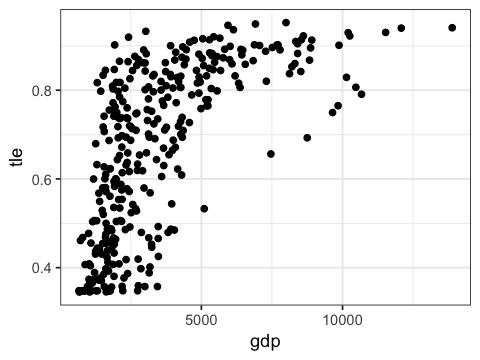

In [6]:
ggplot(df, aes(x=gdp, y=tle)) + geom_point() + theme_bw()

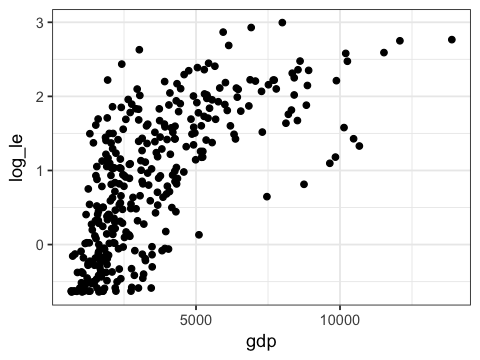

In [7]:
ggplot(df, aes(x=gdp, y=log_le)) + geom_point() + theme_bw()

### Linear model 

In [11]:
linear =  brm(formula = tle ~ gdp, data = df, chains=1)

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'gaussian(identity) brms-model' NOW (CHAIN 1).

Gradient evaluation took 4.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.46 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 9.48499 seconds (Warm-up)
               15.5516 seconds (Sampling)
               25.0366 seconds (Total)



Warning message:
“There were 674 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”

In [14]:
summary(linear)

 Family: gaussian(identity) 
Formula: tle ~ gdp 
   Data: df (Number of observations: 343) 
Samples: 1 chains, each with iter = 2000; warmup = 1000; thin = 1; 
         total post-warmup samples = 1000
    ICs: LOO = NA; WAIC = NA; R2 = NA
 
Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
Intercept     0.48      0.01     0.45     0.51        310    1
gdp           0.00      0.00     0.00     0.00        874    1

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sigma     0.14      0.01     0.14     0.16        113 1.01

Samples were drawn using sampling(NUTS). For each parameter, Eff.Sample 
is a crude measure of effective sample size, and Rhat is the potential 
scale reduction factor on split chains (at convergence, Rhat = 1).

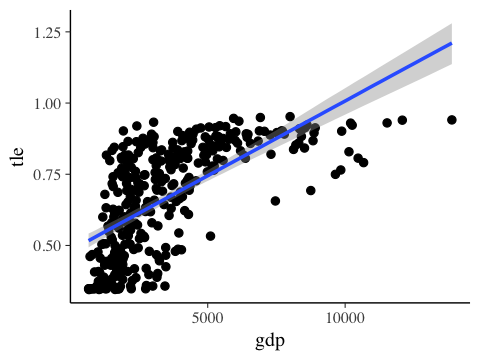

In [13]:
plot(marginal_effects(linear), points = TRUE)

### Preston model

Let's start first using the minpack.lm package to get an idea on priors / initial values.

In [15]:
# estimating starting values for the parameters. Assume alpha=1, then estimate logit(yvar)=beta+gamma^GDP
pars = nls(log_le ~ beta+exp(log(C)*gdp),
      data=df,
      start=list(beta=1,C=1))

In [16]:
nlsFormula = "tle ~ alpha / (1 + exp( beta + exp(log(C) * gdp )))"
nlsInitial = c(alpha=max(df$tle),coef(pars)[1],coef(pars)[2])

In [17]:
model_preston = minpack.lm::nlsLM(formula = nlsFormula,
         data=df,
         start=nlsInitial,
     control=nls.lm.control(maxiter=1000))

In [18]:
summary(model_preston)


Formula: tle ~ alpha/(1 + exp(beta + exp(log(C) * gdp)))

Parameters:
       Estimate Std. Error   t value Pr(>|t|)    
alpha 2.018e+02  5.350e+03     0.038    0.970    
beta  5.405e+00  2.664e+01     0.203    0.839    
C     9.996e-01  7.044e-05 14191.464   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1314 on 340 degrees of freedom

Number of iterations till stop: 96 
Achieved convergence tolerance: 1.49e-08
Reason stopped: Number of calls to `fcn' has reached or exceeded `maxfev' == 400.


In [19]:
# function plot
plot_pred = function(model, x, y) { 
    
    rmse = sqrt(mean(residuals(model)^2))
    
    pred = predict(model)
    
    plot = ggplot(data.frame(x,y,pred), aes(x=x, y=y)) + 
    geom_point() +
    theme_bw() + 
    geom_line(aes(x=x, y=pred))+ 
    labs(title=paste0('RMSE: ', round(rmse, 2)))
    
    return(plot)
    }

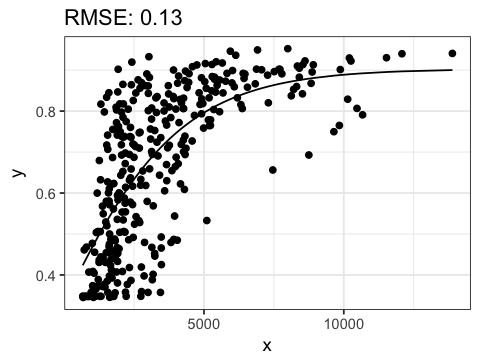

In [20]:
plot_pred(model_preston, df$gdp, df$tle)

####  Stan

In [21]:
dat = df[, .(tle, gdp)]

In [22]:
f = bf(tle ~ alpha / (1 + exp( beta + exp(log(C) * gdp))), 
               alpha + beta + C ~ 1, nl = TRUE)

In [23]:
prior1 = c(prior(normal(5.4, 0.1), nlpar='beta'),
            prior(uniform(0.5,1), lb=0.5, ub=1, nlpar='C'), 
            prior(normal(201.8, 0.1), nlpar='alpha'))

In [24]:
preston = brm(f, data = dat, prior = prior1, chains=1)

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'gaussian(identity) brms-model' NOW (CHAIN 1).

Gradient evaluation took 0.000208 seconds
1000 transitions using 10 leapfrog steps per transition would take 2.08 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 3.8972 seconds (Warm-up)
               9.06128 seconds (Sampling)
               12.9585 seconds (Total)



In [25]:
# posterior <- as.array(preston)
# bayesplot::mcmc_intervals(posterior)

In [26]:
summary(preston)

 Family: gaussian(identity) 
Formula: tle ~ alpha/(1 + exp(beta + exp(log(C) * gdp))) 
         alpha ~ 1
         beta ~ 1
         C ~ 1
   Data: dat (Number of observations: 343) 
Samples: 1 chains, each with iter = 2000; warmup = 1000; thin = 1; 
         total post-warmup samples = 1000
    ICs: LOO = NA; WAIC = NA; R2 = NA
 
Population-Level Effects: 
                Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
alpha_Intercept   201.79      0.10   201.59   201.99        160 1.01
beta_Intercept      5.40      0.03     5.34     5.46        649 1.00
C_Intercept         1.00      0.00     1.00     1.00        771 1.00

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sigma     0.13      0.01     0.12     0.14        782    1

Samples were drawn using sampling(NUTS). For each parameter, Eff.Sample 
is a crude measure of effective sample size, and Rhat is the potential 
scale reduction factor on split chains (at convergence, Rhat = 1).

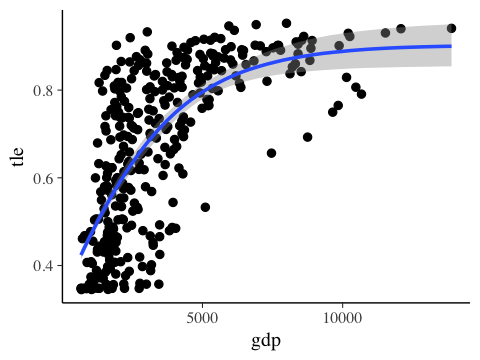

In [27]:
plot(marginal_effects(preston), points = TRUE)

### Logistic

In [28]:
nlsFormula <- "tle ~ alpha / (1 + exp((gdp - gamma) * beta))"

In [29]:
nlsInitial <- c(alpha=max(dat$tle),gamma=mean(dat$gdp),beta=1/mean(df$year))

In [30]:
model_log =  minpack.lm::nlsLM(formula = nlsFormula, 
                       data=dat,
                       start=nlsInitial,
                       control=nls.lm.control(maxiter=1000))

In [31]:
model_log

Nonlinear regression model
  model: tle ~ alpha/(1 + exp((gdp - gamma) * beta))
   data: dat
     alpha      gamma       beta 
 8.831e-01  9.638e+02 -6.011e-04 
 residual sum-of-squares: 5.832

Number of iterations to convergence: 7 
Achieved convergence tolerance: 1.49e-08

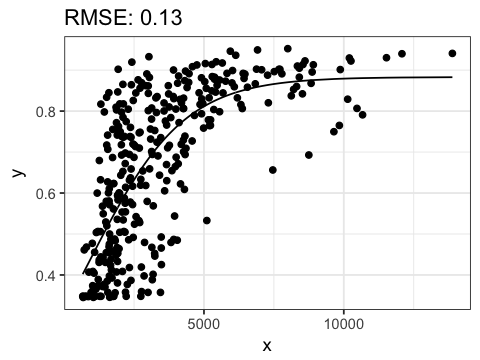

In [32]:
plot_pred(model_log, dat$gdp, dat$tle)

#### Stan

In [33]:
f = bf(tle ~ alpha / (1 + exp((gdp-gamma)*beta)), 
               alpha + beta + gamma ~ 1, nl = TRUE)

In [34]:
prior1 = c(prior(normal(0, 0.05), nlpar='beta'),
            prior(uniform(0,0.5), lb=0, ub=0.5, nlpar='gamma'), 
            prior(normal(0, 0.1), nlpar='alpha'))

This model obviously has problems... just for illustration purposes. 

In [35]:
logistic = brm(f, data = dat, prior = prior1, chains=1)

Compiling the C++ model
Start sampling



SAMPLING FOR MODEL 'gaussian(identity) brms-model' NOW (CHAIN 1).
Rejecting initial value:
  Gradient evaluated at the initial value is not finite.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Gradient evaluated at the initial value is not finite.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Gradient evaluated at the initial value is not finite.
  Stan can't start sampling from this initial value.

Gradient evaluation took 8.7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.87 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)

Warning message:
“There were 14 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”

In [36]:
summary(logistic)

 Family: gaussian(identity) 
Formula: tle ~ alpha/(1 + exp((gdp - gamma) * beta)) 
         alpha ~ 1
         beta ~ 1
         gamma ~ 1
   Data: dat (Number of observations: 343) 
Samples: 1 chains, each with iter = 2000; warmup = 1000; thin = 1; 
         total post-warmup samples = 1000
    ICs: LOO = NA; WAIC = NA; R2 = NA
 
Population-Level Effects: 
                Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
alpha_Intercept     0.84      0.02     0.80     0.88        411 1.00
beta_Intercept      0.00      0.00     0.00     0.00        503 1.01
gamma_Intercept     0.26      0.14     0.01     0.49        627 1.01

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sigma     0.14      0.01     0.13     0.15        530    1

Samples were drawn using sampling(NUTS). For each parameter, Eff.Sample 
is a crude measure of effective sample size, and Rhat is the potential 
scale reduction factor on split chains (at convergence, Rhat = 1).

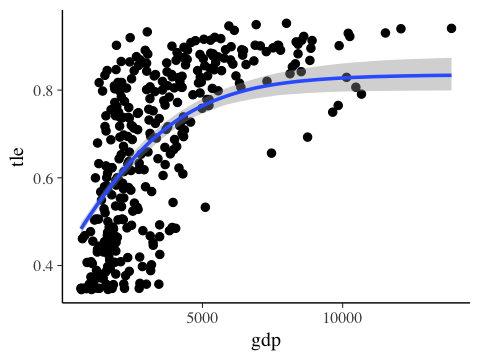

In [37]:
plot(marginal_effects(logistic), points = TRUE)

In [39]:
WAIC(linear, preston, logistic)

                      WAIC    SE
linear             -352.45 19.01
preston            -416.35 24.97
logistic           -386.32 20.98
linear - preston     63.89 12.77
linear - logistic    33.86  9.85
preston - logistic  -30.03  7.49

# Stacking

This is the version of stacking recommended by Gelman at al. [See their paper.](http://www.stat.columbia.edu/~gelman/research/unpublished/combine_predictive.pdf) It has the same logic of the ML solution (prediction) but using a Bayesian approach. 

In [40]:
log_lik_list = list()
log_lik_list[[1]] = log_lik(linear)
log_lik_list[[2]] = log_lik(preston)
log_lik_list[[3]] = log_lik(logistic)

In [41]:
mw = loo::model_weights(log_lik_list, method="stacking")

The stacking weights are:
     [,1]      [,2]      [,3]     
[1,] "Model 1" "Model 2" "Model 3"
[2,] "0"       "1"       "0"      


As expected, all weights are for model 1. 